<a href="https://colab.research.google.com/github/yousrabougara/Text-Toxicity-Detection/blob/main/ToxicityDetection_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Import Modules**

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords')
import csv
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, classification_report

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Load the Dataset**

In [ ]:
df = pd.read_csv('toxicity.csv',encoding ='UTF-8',engine='python',on_bad_lines='skip')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
# dataset stats
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [ ]:
# check for null values
df.isnull().sum()


,0
id,0
comment_text,0
toxic,0
severe_toxic,0
obscene,0
threat,0
insult,0
identity_hate,0


# **Exploratory Data** **Analysis**

In [ ]:
x = df.iloc[:, 2:].sum() # take only label columns
x

,0
toxic,15294
severe_toxic,1595
obscene,8449
threat,478
insult,7877
identity_hate,1405


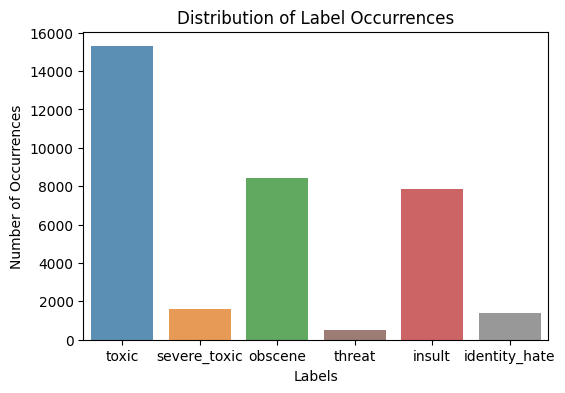

In [ ]:
plt.figure(figsize=(6, 4))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8, palette=['tab:blue', 'tab:orange', 'tab:green', 'tab:brown', 'tab:red', 'tab:grey'])
plt.title('Distribution of Label Occurrences')
plt.ylabel('Number of Occurrences')
plt.xlabel('Labels')

plt.show()


In [ ]:
column_labels = df.columns.tolist()[2:]


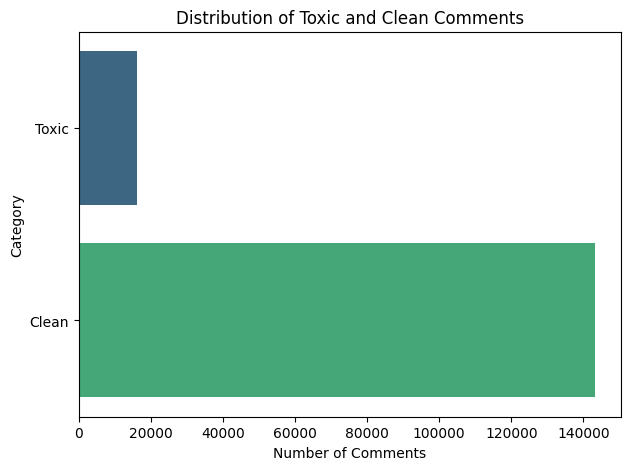

In [ ]:
# Toxic and Non-Toxic Data
# Create subsets based on toxic and clean comments
train_toxic = df[df[column_labels].sum(axis=1) > 0]
train_clean = df[df[column_labels].sum(axis=1) == 0]

# Number of toxic and clean comments
num_toxic = len(train_toxic)
num_clean = len(train_clean)

# Create a DataFrame for visualization
plot_data = pd.DataFrame(
	{'Category': ['Toxic', 'Clean'], 'Count': [num_toxic, num_clean]})

# Create a black background for the plot
plt.figure(figsize=(7, 5))

# Horizontal bar plot
ax = sns.barplot(x='Count', y='Category', data=plot_data, palette='viridis')


# Add labels and title to the plot
plt.xlabel('Number of Comments')
plt.ylabel('Category')
plt.title('Distribution of Toxic and Clean Comments')

# Set ticks' color to white
ax.tick_params()

# Show the plot
plt.show()


In [ ]:
print(train_toxic.shape)
print(train_clean.shape)


(16225, 8)
(143346, 8)


# Handling class imbalance

In [ ]:
# Randomly sample 15,000 clean comments
train_clean_sampled = train_clean.sample(n=16225, random_state=42)

# Combine the toxic and sampled clean comments
df = pd.concat([train_toxic, train_clean_sampled], axis=0)

# Shuffle the data to avoid any order bias during training
df = df.sample(frac=1, random_state=42)


In [ ]:
print(train_toxic.shape)
print(train_clean_sampled.shape)
print(df.shape)


(16225, 8)
(16225, 8)
(32450, 8)


In [ ]:
# Oversample the toxic data to match the number of clean comments
train_toxic_oversampled = resample(
    train_toxic,
    replace=True,        # Sample with replacement
    n_samples=len(train_clean),  # Match the number of clean samples
    random_state=42      # For reproducibility
)

# Combine the oversampled toxic data with the clean data
balanced_df = pd.concat([train_toxic_oversampled, train_clean])

# Shuffle the dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
print(train_toxic_oversampled.shape)
print(train_clean.shape)
print(balanced_df.shape)
balanced_df.to_csv("balanced_toxic_comments.csv", index=False)



(143346, 8)
(143346, 8)
(286692, 8)


# Data Preprocessing

In [ ]:
# remove stopwords
stopwords = set(stopwords.words('english'))

def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stopwords]
    return " ".join(no_stopword_text)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

# stemming
stemmer = SnowballStemmer('english')
def stemming(sentence):
    stemmed_sentence = ""
    for word in sentence.split():
        stemmed_word = stemmer.stem(word)
        stemmed_sentence += stemmed_word + " "

    stemmed_sentence = stemmed_sentence.strip()
    return stemmed_sentence

In [ ]:
# preprocess the comment
balanced_df['comment_text'] = balanced_df['comment_text'].apply(lambda x: remove_stopwords(x))
balanced_df['comment_text'] = balanced_df['comment_text'].apply(lambda x: clean_text(x))
balanced_df['comment_text'] = balanced_df['comment_text'].apply(lambda x: stemming(x))


In [ ]:
balanced_df.to_csv("balanced_toxic_comments_cleaned.csv", index=False)


In [ ]:
# split input and output
X = balanced_df['comment_text']
y = balanced_df.drop(columns=['comment_text','id'], axis=1)

In [ ]:
# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
def run_pipeline(pipeline, X_train, X_test, y_train, y_test):
    # train model
    pipeline.fit(X_train, y_train)
    # predict from model
    predictions = pipeline.predict(X_test)
    pred_probs = pipeline.predict_proba(X_test)
    # print metrics
    print('roc_auc:', roc_auc_score(y_test, pred_probs))
    print('accuracy:', accuracy_score(y_test, predictions))
    print('classification report')
    print(classification_report(y_test, predictions, target_names=y_train.columns))

In [ ]:
NB_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('nb_model', OneVsRestClassifier(MultinomialNB(), n_jobs=-1))
])

LR_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('nb_model', OneVsRestClassifier(LogisticRegression(), n_jobs=-1))
])

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RF_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('rf_model', OneVsRestClassifier(RandomForestClassifier(), n_jobs=-1))
])

In [ ]:
from xgboost import XGBClassifier

XGB_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('xgb_model', OneVsRestClassifier(XGBClassifier(), n_jobs=-1))
])


In [ ]:
run_pipeline(NB_pipeline, X_train, X_test, y_train, y_test)

roc_auc: 0.9250740702494317
accuracy: 0.7000819686426342
classification report
               precision    recall  f1-score   support

        toxic       0.89      0.90      0.90     26933
 severe_toxic       0.97      0.07      0.14      2866
      obscene       0.93      0.67      0.78     14896
       threat       0.88      0.01      0.02       860
       insult       0.91      0.59      0.71     13874
identity_hate       0.97      0.07      0.12      2432

    micro avg       0.91      0.69      0.78     61861
    macro avg       0.93      0.38      0.44     61861
 weighted avg       0.91      0.69      0.75     61861
  samples avg       0.42      0.35      0.37     61861



In [ ]:
run_pipeline(LR_pipeline, X_train, X_test, y_train, y_test)

roc_auc: 0.9876456100190444
accuracy: 0.8084375381502991
classification report
               precision    recall  f1-score   support

        toxic       0.93      0.94      0.94     26933
 severe_toxic       0.82      0.52      0.63      2866
      obscene       0.94      0.87      0.91     14896
       threat       0.88      0.49      0.63       860
       insult       0.90      0.81      0.85     13874
identity_hate       0.90      0.58      0.71      2432

    micro avg       0.92      0.85      0.89     61861
    macro avg       0.90      0.70      0.78     61861
 weighted avg       0.92      0.85      0.88     61861
  samples avg       0.44      0.42      0.42     61861



In [ ]:
run_pipeline(RF_pipeline, X_train, X_test, y_train, y_test)

roc_auc: 0.9999117300798438
accuracy: 0.990111442473709
classification report
               precision    recall  f1-score   support

        toxic       0.99      1.00      0.99     26933
 severe_toxic       0.97      0.98      0.98      2866
      obscene       1.00      1.00      1.00     14896
       threat       0.98      1.00      0.99       860
       insult       1.00      0.99      0.99     13874
identity_hate       0.99      0.99      0.99      2432

    micro avg       0.99      1.00      0.99     61861
    macro avg       0.99      0.99      0.99     61861
 weighted avg       0.99      1.00      0.99     61861
  samples avg       0.50      0.50      0.50     61861



In [ ]:
run_pipeline(XGB_pipeline, X_train, X_test, y_train, y_test)

roc_auc: 0.9828797191872579
accuracy: 0.7705052407610876
classification report
               precision    recall  f1-score   support

        toxic       0.95      0.84      0.89     26933
 severe_toxic       0.93      0.56      0.70      2866
      obscene       0.94      0.85      0.89     14896
       threat       0.98      0.81      0.89       860
       insult       0.87      0.73      0.79     13874
identity_hate       0.94      0.70      0.80      2432

    micro avg       0.93      0.80      0.86     61861
    macro avg       0.93      0.75      0.83     61861
 weighted avg       0.93      0.80      0.86     61861
  samples avg       0.40      0.38      0.38     61861



# Test Prediction

In [ ]:
labels = y_train.columns.values
labels

array(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'], dtype=object)

In [ ]:
sentence = 'I hate you idiot'
stemmed_sentence = stemming(sentence)
results = LR_pipeline.predict([stemmed_sentence])[0]
for label, result in zip(labels, results):
    print("%14s %5s" % (label, result))

         toxic     1
  severe_toxic     0
       obscene     1
        threat     0
        insult     1
 identity_hate     0


In [ ]:
sentence = 'hello how are you doing'
stemmed_sentence = stemming(sentence)
results = LR_pipeline.predict([stemmed_sentence])[0]
for label, result in zip(labels, results):
    print("%14s %5s" % (label, result))

         toxic     0
  severe_toxic     0
       obscene     0
        threat     0
        insult     0
 identity_hate     0


# ROC Curve

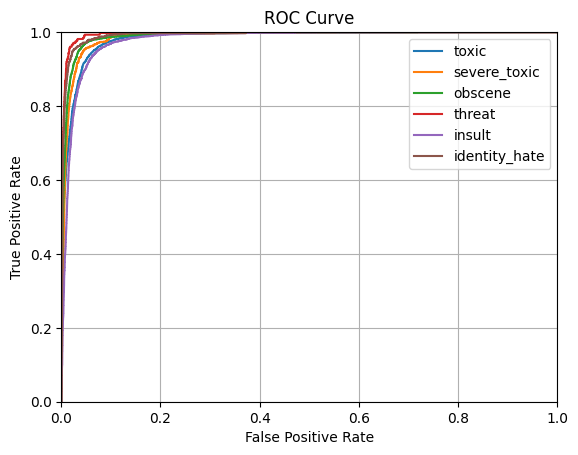

In [ ]:
def plot_roc_curve(test_labels, predict_prob):
    fpr, tpr, thresholds = roc_curve(test_labels, predict_prob)
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.legend(labels)

def plot_pipeline_roc_curve(pipeline, X_train, X_test, y_train, y_test):
    for label in labels:
        pipeline.fit(X_train, y_train[label])
        pred_probs = pipeline.predict_proba(X_test)[:, 1]
        plot_roc_curve(y_test[label], pred_probs)

plot_pipeline_roc_curve(LR_pipeline, X_train, X_test, y_train, y_test)